In [117]:
pip install plotly --upgrade

Note: you may need to restart the kernel to use updated packages.


In [38]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import requests
import pickle

In [39]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [40]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,pickup_hour,dropoff_hour,dayofweek
0,id2875421,B,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,0.017680,0.000039,17,17,0
1,id3194108,A,2016-06-01 11:48:41,2016-06-01 12:19:07,1,-74.005028,40.746452,-73.972008,40.745781,N,1826,7.509883,0.033027,0.000018,11,12,2
2,id3564028,A,2016-01-02 01:16:42,2016-01-02 01:19:56,1,-73.954132,40.774784,-73.947418,40.779633,N,194,5.267858,0.008282,0.000043,1,1,5
3,id1660823,B,2016-03-01 06:40:18,2016-03-01 07:01:37,5,-73.982140,40.775326,-74.009850,40.721699,N,1279,7.153834,0.060363,0.000047,6,7,1
4,id1575277,B,2016-06-11 16:59:15,2016-06-11 17:33:27,1,-73.999229,40.722881,-73.982880,40.778297,N,2052,7.626570,0.057778,0.000028,16,17,5


#| title: 요일,시간에 따른 평균이동거리 시각화

In [41]:
speed = pd.Series([1,1,2,2,3,3,4,4])
print(pd.qcut(speed,4))
print(pd.qcut(speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름']))

0    (0.999, 1.75]
1    (0.999, 1.75]
2      (1.75, 2.5]
3      (1.75, 2.5]
4      (2.5, 3.25]
5      (2.5, 3.25]
6      (3.25, 4.0]
7      (3.25, 4.0]
dtype: category
Categories (4, interval[float64, right]): [(0.999, 1.75] < (1.75, 2.5] < (2.5, 3.25] < (3.25, 4.0]]
0    매우느림
1    매우느림
2    조금느림
3    조금느림
4    조금빠름
5    조금빠름
6    매우빠름
7    매우빠름
dtype: category
Categories (4, object): ['매우느림' < '조금느림' < '조금빠름' < '매우빠름']


/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



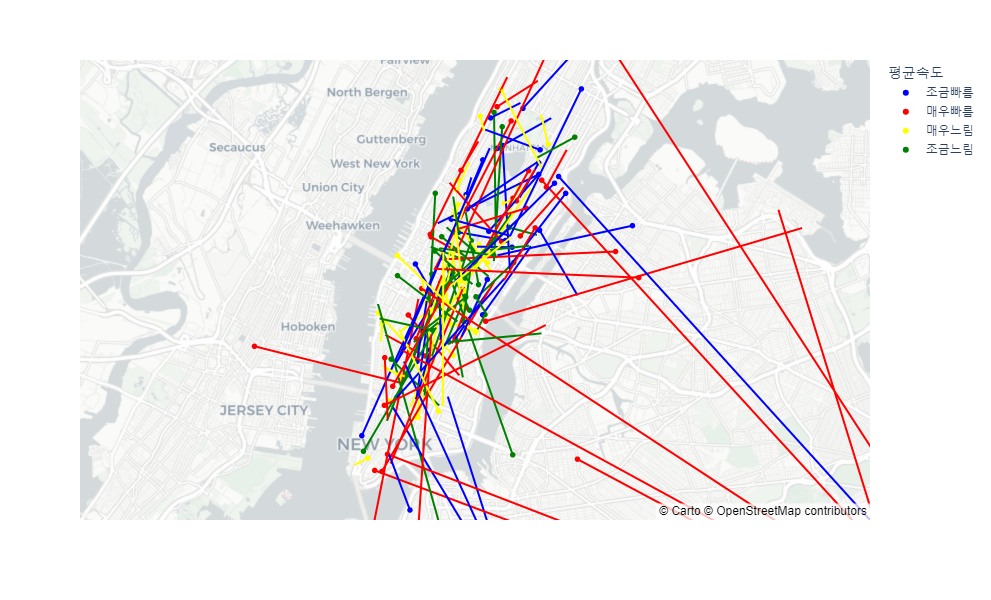

In [47]:
df_small['평균속도'] = pd.qcut(df_small['speed'], 4, labels=['매우느림', '조금느림', '조금빠름', '매우빠름'])

# 색상 매핑을 위한 딕셔너리 생성
color_map = {
    '매우느림': 'yellow',
    '조금느림': 'green',
    '조금빠름': 'blue',
    '매우빠름': 'red'
}

# Scatter Mapbox 생성
fig = px.scatter_mapbox(
    data_frame=df_small,
    lat='dropoff_latitude',
    lon='dropoff_longitude',
    color='평균속도',
    mapbox_style='carto-positron',
    zoom=11,
    width=750,
    height=600,
    color_discrete_map=color_map  # 색상 매핑을 적용합니다.
)

# 속도 구간에 따라 승차와 하차 지점을 연결하는 선 추가
for index, row in df_small.iterrows():
    fig.add_trace(
        dict(
            type='scattermapbox',
            lat=[row['pickup_latitude'], row['dropoff_latitude']],
            lon=[row['pickup_longitude'], row['dropoff_longitude']],
            mode='lines',
            line=dict(width=2, color=color_map[row['평균속도']]),  # 속도 구간에 따라 색상 설정
            hoverinfo='none',
            showlegend=False
        )
    )

fig.show(config={'scrollZoom': False})